# Save a movie showing a few instances of giving up

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rc('font', family='arial') 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib import cm

import numpy as np
from skimage.io import imread
from fish.image.zds import ZDS
from fish.ephys.ephys import load
from fish.util.distributed import get_cluster
import dask.array as da
from dask.distributed import Client
from dask.array import coarsen
from dask.delayed import delayed
from functools import partial
from dask import threaded
from h5py import File
import flika as flk
import time
import attr
flk.start_flika()

from skimage.transform import downscale_local_mean
from scipy.ndimage.filters import median_filter

from skimage.exposure import rescale_intensity as rescale
from scipy.ndimage.filters import gaussian_filter
from moviepy.editor import ImageSequenceClip, VideoClip, concatenate_videoclips
from moviepy.video.io.bindings import mplfig_to_npimage

Starting flika
Starting flika inside IPython


In [2]:
def mydff(v):
    from fish.image.vol import dff
    camera_offset = 80
    window = 400
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0]    
    return shift(im.astype('float32'), (0,0, *shifts[t]), order=1, cval=100)

def rearrange(im):
    mp = im.shape[1]//2
    hemi = np.concatenate([im[:,:mp], im[:,mp:]], axis=2)
    padded = np.pad(hemi, ((0,0), (29,29), (29,29), (0,0)), mode='constant')
    mont = montage(padded, rgb=True)
    return mont

def montage(vol, rgb=False):
    if rgb:
        if vol.ndim == 4:
            return vol.reshape(vol.shape[0] * vol.shape[1], vol.shape[2], vol.shape[3])
        elif vol.ndim == 5:
            return vol.reshape(vol.shape[0], vol.shape[1] * vol.shape[2], vol.shape[3], vol.shape[4])
    else:
        if vol.ndim == 4:
            return vol.reshape(vol.shape[0], vol.shape[1] * vol.shape[2], vol.shape[3])
        elif vol.ndim == 5:
            return vol.reshape(vol.shape[0], vol.shape[1] * vol.shape[2], vol.shape[3], vol.shape[4])

In [3]:
base_dir = '/nrs/ahrens/Yu/SPIM/active_dataset/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/'
ephys = File(base_dir + 'ephys/data.mat')['data']
gain_signal = np.squeeze(File(base_dir + 'ephys/rawdata.mat')['rawdata/stimGain'][:])
swims = np.squeeze(ephys['fltCh1'][:] + ephys['fltCh2'][:])
cam = np.squeeze(ephys['frame'][:]) - 1
shifts = -np.load(base_dir + 'regparams_affine.npy')[:,:-1,-1]
shifts = median_filter(shifts, size=(300,1))
dset = ZDS(base_dir + 'raw/')
exp_name = dset.metadata['data_header']
planes = np.linspace(5, dset.shape[1]-3, 5).astype('int')
zstep = int(np.diff(planes[:2]))
fs_im = dset.metadata['volume_rate']
print(planes)

[ 5 10 15 20 26]


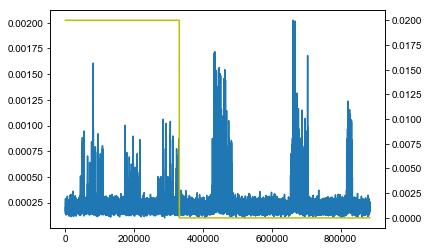

In [4]:
roi = (slice(292, 525), slice(planes[0], planes[-1], zstep), slice(None), slice(None))
plr = slice(np.where(cam == roi[0].start)[0][0], np.where(cam==roi[0].stop)[0][0])
plt.plot(swims[plr])
plt.twinx().plot(gain_signal[plr], color='y')

In [5]:
%%time
data = dset.data[roi]
data_tx = data.map_blocks(shift_yx, shifts[roi[0]], dtype='float32')
medfilt = partial(median_filter, size=(1,1,5,5))
data_filt = data_tx.map_blocks(medfilt)

ds_xy = 4
data_ds = coarsen(np.mean, data_filt, {2: ds_xy, 3: ds_xy})
rechunked = data_ds.rechunk(chunks=(data_ds.shape[0], 1, 'auto','auto'))
data_dff = rechunked.map_blocks(mydff, dtype='float32')

ref_range = slice(0, 10)
ref = data_ds[ref_range].mean(0).compute(scheduler='threads')
out_path = f'/groups/ahrens/ahrenslab/davis/tmp/{exp_name}_t{roi[0].start}t{roi[0].stop}.npy'

CPU times: user 2min 45s, sys: 4.86 s, total: 2min 50s
Wall time: 48 s


In [6]:
cluster = get_cluster()
cluster.adapt()
client = Client(cluster)
client

Client Scheduler: tcp://10.36.110.35:43622 Dashboard: http://10.36.110.35:45455/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [14]:
%%time
result_dff = data_dff.compute()
#cluster.cleanup_closed_workers()

CPU times: user 41.7 s, sys: 32.4 s, total: 1min 14s
Wall time: 2min 29s


In [15]:
np.save(out_path, result_dff)

In [6]:
result_dff = np.load(out_path)
# crop the image to remove dff artifacts induced by motion correction
crop = (slice(None), slice(None), slice(10, -10), slice(10, -10))
cropped=result_dff[crop]

In [7]:
gammas = [.5,1]
bg = (255 * (cm.gray(rescale(gaussian_filter(ref, sigma=(0,1,1))[crop[-3], crop[-2], crop[-1]],in_range=(102, 250), out_range=(0,.5)) ** gammas[0])[:,:,:,:-1])).astype('int')

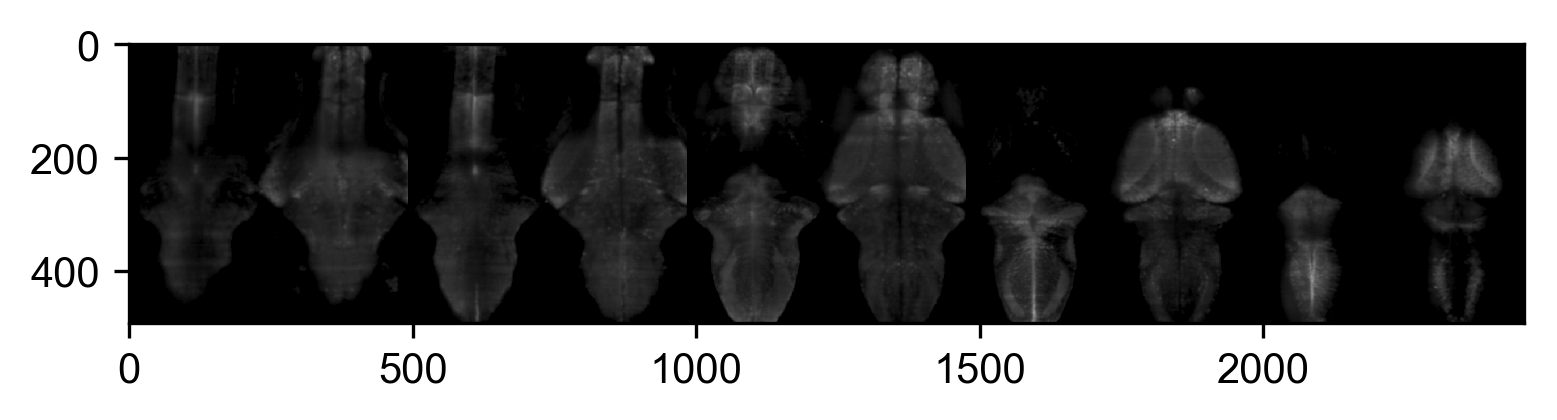

In [8]:
fig, axs = plt.subplots(dpi=300)
plt.imshow(montage(bg, rgb=True).transpose(1,0,2))

## Make the data video

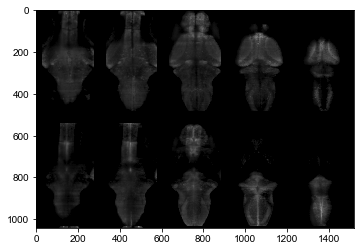

In [9]:
plt.imshow(np.roll(rearrange(bg).transpose(1,0,2), 512, axis=0))

In [11]:
dset.metadata['volume_rate']

1.58

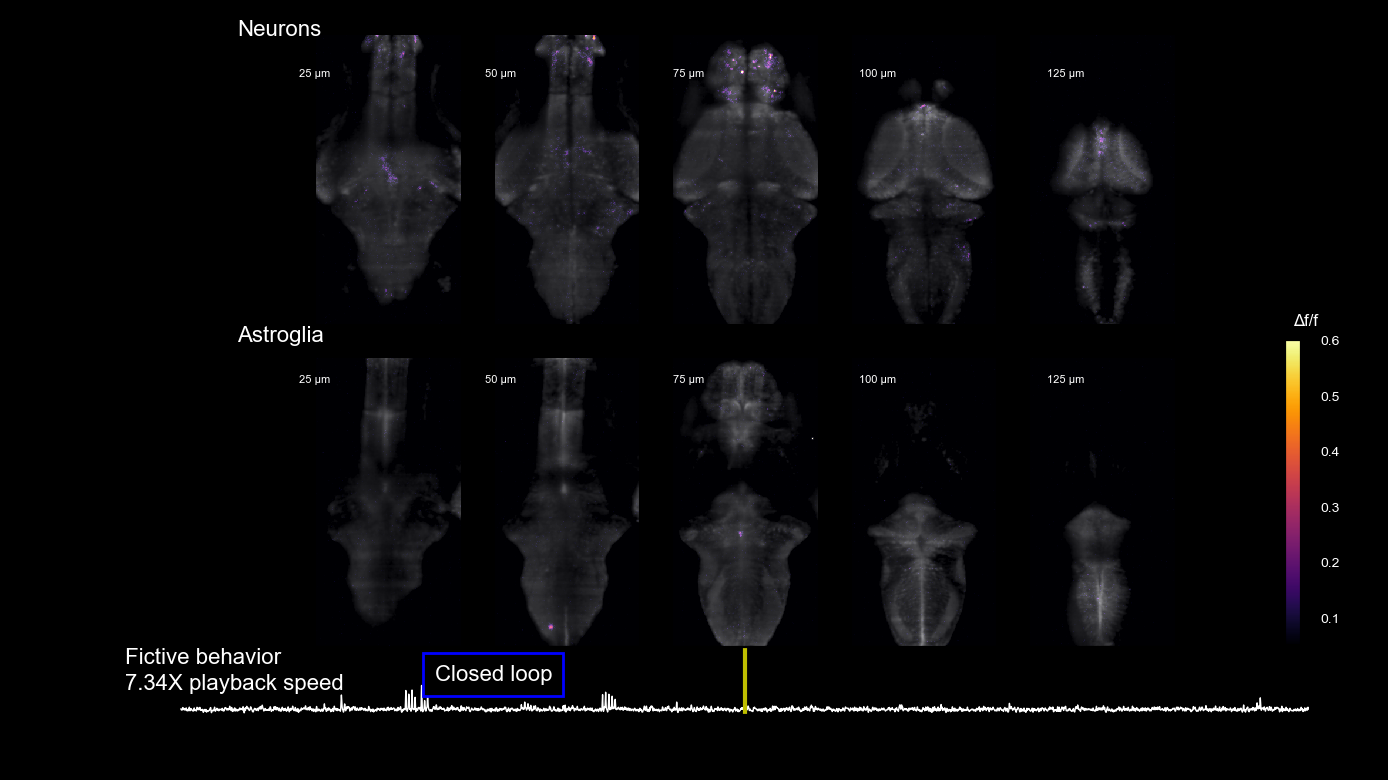

In [27]:
sample = rearrange(bg).transpose(1,0,2)
fs_ep = 6000
flash_dur = fs_ep * 10
title_dur = 4
data_dur = 20
ind = 0
fps = (cropped.shape[0] - 1) / data_dur
fd_big = {'fontsize' : 8, 'color' : (1, 1, 1)}
fd_small = {'fontsize' : 4, 'color' : (1, 1, 1)}
im_label_x = -105
gain_conds = ('Closed loop', 'Open loop')
gain_colors = ('b','y')
ep_label = 'Fictive behavior'

gammas = [.5,1]
bg = (255 * (cm.gray(rescale(gaussian_filter(ref, sigma=(0,1,1))[crop[-3], crop[-2], crop[-1]],in_range=(102, 250), out_range=(0,.5)) ** gammas[0]))).astype('int')

dff_range = (.05,.6)
ep_window = np.arange(-8 * fs_ep, 8 * fs_ep)

zlabel_x = np.linspace(0, sample.shape[1] - bg.shape[1] //2, bg.shape[0]).astype('int')
zlabel_y = np.array([0, sample.shape[0]//2]) + 70
zlabels = [z.astype('str') + ' µm' for z in np.arange(dset.shape[1])[roi[1]] * zstep]
im_ar = rearrange(bg).shape[0] / rearrange(bg).shape[1]
figsize=(8, 4.5)
fig = plt.figure(dpi=200, figsize=figsize, facecolor='k')
gsp = gs.GridSpec(10,10)
ax_im = fig.add_subplot(gsp[:-1,:])
ax_im.imshow(np.random.randn(*sample.shape[:-1]), cmap='inferno', clim=dff_range)
ax_im_pos = ax_im.get_position()
ax_im.axis('off')

ax_ep = fig.add_subplot(gsp[-1,:])
ax_ep.set_facecolor('k')
ax_cbar = fig.add_axes((ax_im_pos.xmax - .05, ax_im_pos.ymin, .01, ax_im_pos.height/2))
cbar = plt.colorbar(ax_im.images[0], cax = ax_cbar)
ax_cbar.text(.5, 1.05, '\u0394f/f', transform=ax_cbar.transAxes, fontdict={'fontsize' : 6, 'color' : (1, 1, 1)})

ax_cbar.set_facecolor('k')
ax_cbar.tick_params(labelcolor='w', labelsize=5)
dff_range = (.05, .6)
fig.subplots_adjust(hspace=0)

timing_label = dict(x = 0, y = .37, s=f'{fps/dset.metadata["volume_rate"]:.2f}X playback speed',transform=ax_ep.transAxes, fontdict=dict(color='w', size=8))
[ax_im.text(x, y, zlabels[ind], fontdict=fd_small) for y in zlabel_y for ind, x in enumerate(zlabel_x)]
ax_im.text(im_label_x, sample.shape[0] //2, 'Astroglia', fontdict=fd_big)
ax_im.text(im_label_x, 0, 'Neurons', fontdict=fd_big)
ax_ep.text(**timing_label)
ax_ep.plot()
ax_ep.set_ylim(swims.min(), swims.max() / 3)
t_s_label = ax_ep.text(0, .75, ep_label.format(0), transform=ax_ep.transAxes, fontdict=fd_big)
t_ep = np.where(cam == ind + roi[0].start)[0][0]
ep_plr = ep_plr = t_ep + ep_window    
ax_ep.plot(ep_window, swims[ep_plr], color='w', linewidth=.5)
ax_ep.axvline(0, color='y')

cond_label = ax_ep.text(.25, 
                        .5, 
                        gain_conds[(gain_signal[t_ep] == 0.0).astype('int')], 
                        transform=ax_ep.transAxes, 
                        fontdict=fd_big, 
                        bbox=dict(edgecolor=gain_colors[(gain_signal[t_ep] == 0.0).astype('int')], facecolor='k'))

def drawf(t_):    
    global ind
    
    if t_ == 0.0:
        ind = 0
        
    t_s = ind / fs_im
    im = cropped[ind].squeeze()
    composite = bg + rescale(cm.inferno(rescale(im, in_range=dff_range)), out_range='uint8').astype('uint8')
    mont = rearrange(composite).transpose(1,0,2)
    
    try:
        ax_im.images[0].set_data(np.roll(mont, mont.shape[0]//2, axis=0))                
    except IndexError:
        ax_im.imshow(np.roll(mont, mont.shape[0]//2, axis=0))                
            
    t_ep = np.where(cam == ind + roi[0].start)[0][0]        
    
    # make the bounding box blink at 1 fps for ~3s after open loop starts
    gain_switched = (gain_signal[t_ep] == 0.0) and (gain_signal[t_ep - flash_dur] > 0.0)    
    g_ind = (gain_signal[t_ep] == 0.0).astype('int')
    
    ep_plr = t_ep + ep_window    
    ax_ep.lines[0].set_data(ep_window, swims[ep_plr])  
    t_s_label.set_text(ep_label.format(t_s))

    cond_box_label_color = gain_colors[g_ind]
    if gain_switched:
        cond_box_label_color=gain_colors[ind % 2]    
    cond_label.set_text(gain_conds[g_ind])
    cond_label.set_bbox(dict(edgecolor=cond_box_label_color, facecolor='k'))
    
    ind += 1
    return mplfig_to_npimage(fig)

data_clip = VideoClip(drawf, duration=data_dur)


$\it{Tg(elavl3:GCaMP6f)}$, $\it{Tg(gfap:jRGECO1b)}$ transgenic zebrafish
            performing fictive behavior in a virtual 1D environment during brain-wide 
            volumetric imaging.
            
            When the experimental condition changes from closed loop to open loop,
            the fish swims vigorously and enters a passive behavioral state.
            
            This behavioral transition correlates with distinct patterns of calcium activity
            in neurons and astroglia.

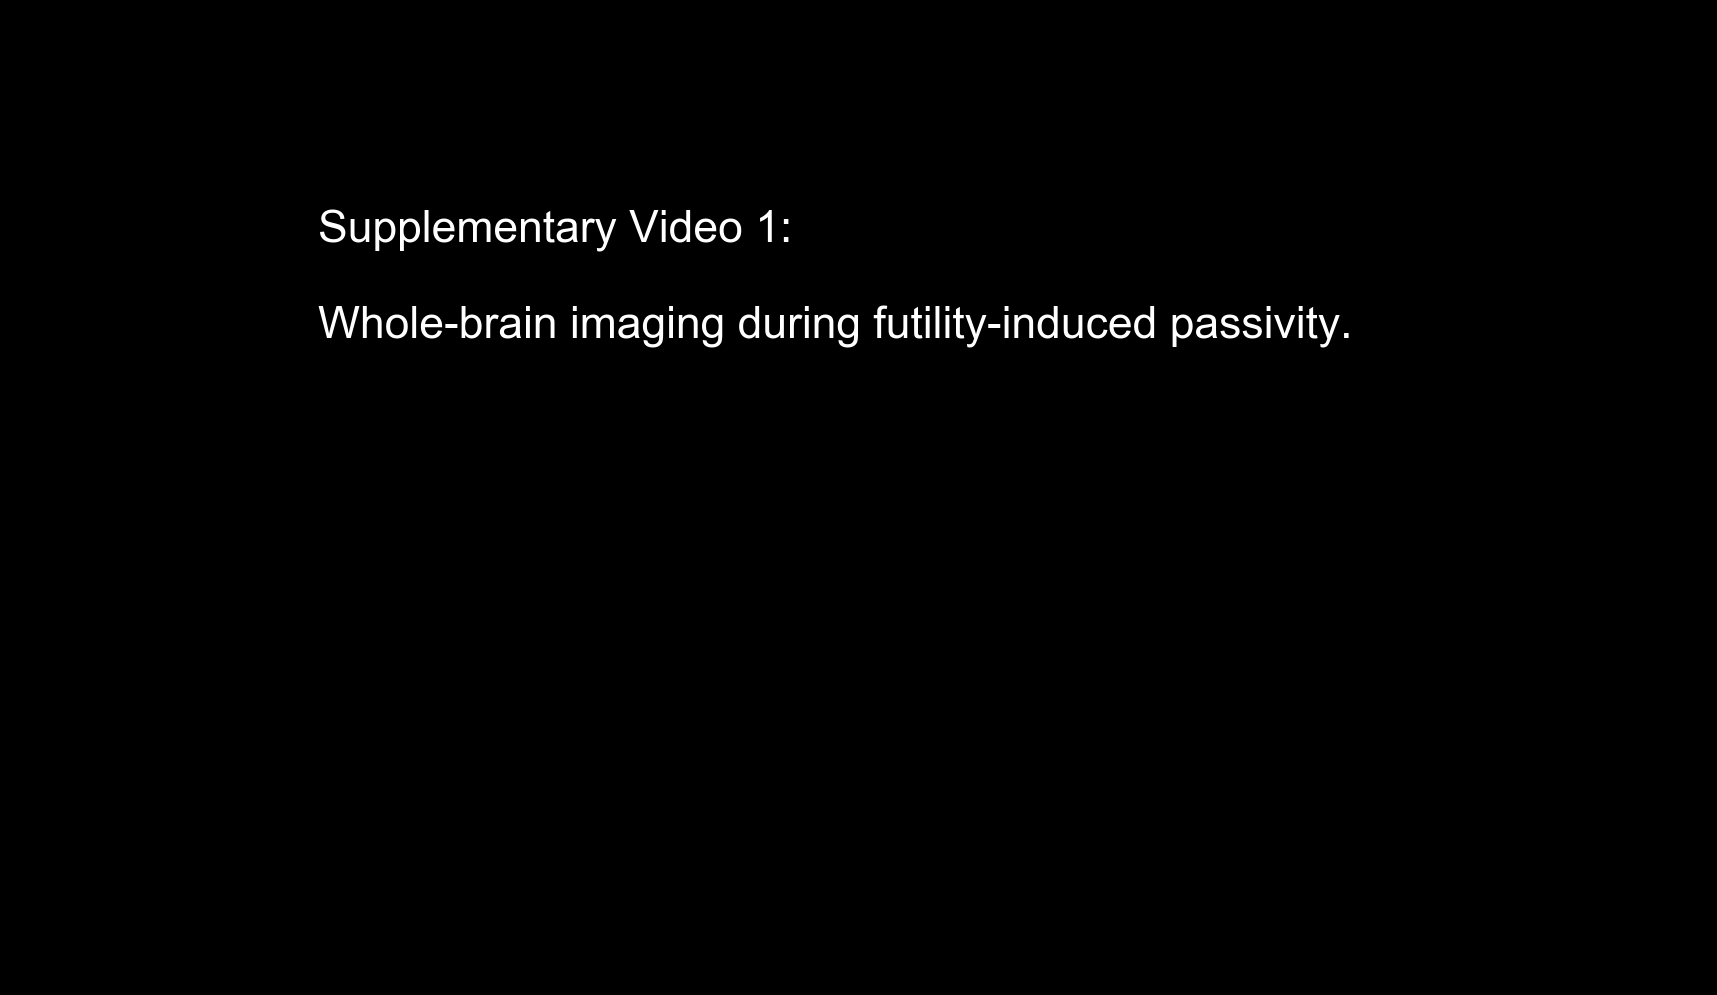

In [28]:
fig_intro = plt.figure(dpi=200, figsize=figsize, facecolor='k')
ax_intro = fig_intro.add_axes((0,0,1,1))
ax_intro.set_facecolor('k')

intro_text =r'''Supplementary Video 1:

Whole-brain imaging during futility-induced passivity.'''
            
ax_intro.text(.15,
              .8,
              intro_text, 
              fontdict=dict(color='w',size=16), 
              transform=ax_intro.transAxes,            
              ha = 'left',
              va='top',
             multialignment='left')

def drawf_intro(t_):
    return mplfig_to_npimage(fig_intro)

title_clip = VideoClip(drawf_intro, duration=title_dur)

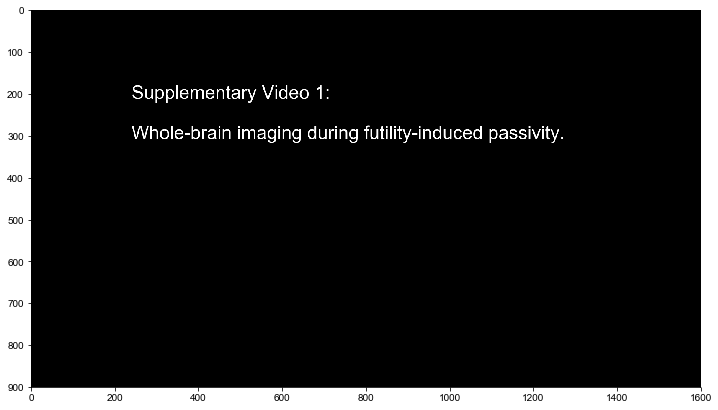

In [29]:
_,_  = plt.subplots(figsize=(12,12))
plt.imshow(drawf_intro(0))

In [30]:
import shutil
codec = 'h264'
vid_fname = f'/groups/ahrens/ahrenslab/davis/tmp/{exp_name}_t{roi[0].start}t{roi[0].stop}.mp4'
ind = 0
composite_clip = concatenate_videoclips([title_clip, data_clip], method='compose')
composite_clip.write_videofile(vid_fname, audio=False, codec=codec, fps=fps, ffmpeg_params=['-pix_fmt', 'yuv420p'])
shutil.copyfile(vid_fname, '/groups/ahrens/ahrenslab/davis/tmp/Supplementary_Video_1.mp4')

[MoviePy] >>>> Building video /groups/ahrens/ahrenslab/davis/tmp/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_t292t525.mp4
[MoviePy] Writing video /groups/ahrens/ahrenslab/davis/tmp/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_t292t525.mp4


100%|██████████| 279/279 [01:50<00:00,  2.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /groups/ahrens/ahrenslab/davis/tmp/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_t292t525.mp4 



'/groups/ahrens/ahrenslab/davis/tmp/Supplementary_Video_1.mp4'